In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import math
import pycolmap


# plt.rcParams.update({'font.size': 16})


In [2]:
def getAUC(errors, threshold_list):
    auc = []

    for threshold in threshold_list:
        auc.append(np.sum(errors < threshold)/len(errors))

    return auc

In [ ]:
def plotCDF_all(results, method_names, skip_name = []):
    method_names_ = method_names.copy()
    error_names = ['R Error (deg)', 't Error (cm)', 'f Error (%)', 'Runtime (ms)', 'Iterations', 'Num Inliers']
    error_limits = [50, 50, 200, 1000]
    n = len(method_names)

    plt.figure(figsize=(10, 6))
    for i in range(len(error_names)):
        plt.subplot(2, 3, i+1)
        for j in range(n):
            if method_names[j] in skip_name:
                continue
            sns.ecdfplot(results[:,i+j*6])
        plt.xlabel(error_names[i])
        plt.ylabel('CDF')

    for name_ in method_names:
        if name_ in skip_name:
            method_names_.remove(name_)

    plt.legend(method_names_)
    plt.tight_layout()
    plt.show()



In [4]:
def collectErrors(errors, method_names):
    assert len(errors[list(errors.keys())[0]]) == len(method_names)*6

    results = []
    for query_name in errors.keys():
        results.append(errors[query_name])
    results = np.array(results)

    return results

In [5]:
def showErrors(errors, method_names):
    
    top_level_headers = ['R Error (deg)', 't Error (cm)', 'f Error (%)', 'Runtime (ms)', 'Iterations', 'Num Inliers']

    table = np.reshape(errors, (len(method_names), 6))
    df = pd.DataFrame(table, columns=top_level_headers, index=method_names)

    return df

In [6]:
def getAUC(errors, R_idx, t_idx, R_thrs, t_thrs):
    n = errors.shape[0]
    assert len(R_thrs) == len(t_thrs)
    
    auc = []
    for j in range(len(R_thr)):
        auc_ = 0
        for i in range(n):
            if errors[i,R_idx] < R_thrs[j] and errors[i,t_idx] < t_thrs[j]:
                auc_ += 1
        auc.append(auc_/n)
    return auc

# Dataset statistics

In [7]:
scene_list = ["festia_out_corridor", "sportunifront", "parakennus_out", "main_campus", "Kitchen_In", "meetingroom", "night_out", "outcorridor", "parakennus", "upstairs"]

# larger sequence 0, 1, 3, 9
scene = scene_list[2]
gt_dirs = Path("/home2/xi5511zh/Xinyue/Datasets/Fisheye_FIORD")
results_dir = gt_dirs / scene / "processed_remove_neighbours/hloc/RANSACresults_remove_neighbours.pkl"
method_names = ['p3p', 'P4Pfr_LM', 'P4Pfr_HC_pose', 'P4Pfr_HC_depth', 'P3P_sampling_LM', 'P3P_sampling_HC']


In [8]:
# dataset_stats = []

# for scene in scene_list:
#     gt_sfm = gt_dirs / scene / "colmap/model"
#     gt_sfm = pycolmap.Reconstruction(gt_sfm)
#     nTotal = len(gt_sfm.images)

#     ref_sfm = gt_dirs / scene / "processed_remove_neighbours/colmap"
#     ref_sfm = pycolmap.Reconstruction(ref_sfm)
#     nDatabase = len(ref_sfm.images)

#     query_results = gt_dirs / scene / "processed_remove_neighbours/hloc/RANSACresults_remove_neighbours.pkl"
#     with open(query_results, 'rb') as f:
#         query_results = pickle.load(f)
#     nQuery = len(list(query_results.keys()))

#     dataset_stats.append({"scene": scene, "nTotal": nTotal, "nDatabase": nDatabase, "nQuery": nQuery})
    
#     del gt_sfm, ref_sfm

# dataset_stats = pd.DataFrame(dataset_stats)
# dataset_stats


# load results

In [9]:
with open(results_dir, 'rb') as f:
    errors = pickle.load(f)
results = collectErrors(errors, method_names)

In [10]:
medianError = np.median(results, axis=0)
df_median = showErrors(medianError, method_names)
df_median

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,4.116694,57.549526,0.000000,11.489520,101.0,2130.0
P4Pfr_LM,0.587773,9.585005,18.458294,199.038265,1669.0,722.0
P4Pfr_HC_pose,0.578135,9.585005,10.705743,413.796123,1689.0,726.0
P4Pfr_HC_depth,0.577567,9.371493,13.095842,321.696890,1689.0,723.0
P3P_sampling_LM,0.568992,10.998310,14.987570,332.003486,1640.0,723.0
P3P_sampling_HC,0.577567,8.828329,13.619228,972.360700,1689.0,726.0


In [11]:
meanError = np.mean(results, axis=0)
df_mean = showErrors(meanError, method_names)
df_mean

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,5.345333,81.635017,0.000000,12.682508,101.000000,2025.925926
P4Pfr_LM,2.227967,25.245711,40.382398,191.789940,1430.111111,723.296296
P4Pfr_HC_pose,1.956600,24.335671,35.180165,389.816229,1431.222222,724.259259
P4Pfr_HC_depth,1.932987,23.830017,35.895357,311.840339,1430.370370,721.259259
P3P_sampling_LM,2.252339,25.242706,38.761892,293.035952,1419.185185,723.962963
P3P_sampling_HC,2.080606,24.732781,37.153031,835.834679,1429.666667,724.407407


# AUC

In [12]:
R_thr = [1, 1, 2, 5, 5]
t_thr = [1, 2, 5, 5, 10]
f_thr = [1, 2, 5, 10, 50]

In [13]:
AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results, m_idx*6, m_idx*6+1, R_thr, t_thr)
    AUC.append({'method': method_names[m_idx], f"{R_thr[0]}deg, {t_thr[0]}cm": f"{auc_[0]*100:.2f}", 
        f"{R_thr[1]}deg, {t_thr[1]}cm": f"{auc_[1]*100:.2f}", f"{R_thr[2]}deg, {t_thr[2]}cm": f"{auc_[2]*100:.2f}",
        f"{R_thr[3]}deg, {t_thr[3]}cm": f"{auc_[3]*100:.2f}", f"{R_thr[4]}deg, {t_thr[4]}cm": f"{auc_[4]*100:.2f}", "mean time (ms)": f"{results[m_idx, m_idx*6+3]:.2f}"})
AUC = pd.DataFrame(AUC)
AUC


,method,"1deg, 1cm","1deg, 2cm","2deg, 5cm","5deg, 5cm","5deg, 10cm",mean time (ms)
0,p3p,0.00,0.00,0.00,0.00,0.00,3.63
1,P4Pfr_LM,0.00,11.11,40.74,40.74,51.85,199.04
2,P4Pfr_HC_pose,0.00,14.81,44.44,44.44,55.56,283.94
3,P4Pfr_HC_depth,0.00,11.11,44.44,44.44,55.56,177.62
4,P3P_sampling_LM,0.00,11.11,40.74,40.74,48.15,332.00
5,P3P_sampling_HC,0.00,11.11,44.44,44.44,51.85,379.25


In [14]:
AUC = []
for m_idx in range(len(method_names)):
    auc_ = getAUC(results, m_idx*6+1, m_idx*6+2, t_thr, f_thr)
    AUC.append({'method': method_names[m_idx], f"{R_thr[0]}cm, {t_thr[0]}px": f"{auc_[0]*100:.2f}", 
        f"{R_thr[1]}cm, {t_thr[1]}px": f"{auc_[1]*100:.2f}", f"{R_thr[2]}cm, {t_thr[2]}px": f"{auc_[2]*100:.2f}", 
        f"{R_thr[3]}cm, {t_thr[3]}px": f"{auc_[3]*100:.2f}", f"{R_thr[4]}cm, {t_thr[4]}px": f"{auc_[4]*100:.2f}", "mean time (ms)": f"{results[m_idx, m_idx*6+3]:.2f}"})
AUC = pd.DataFrame(AUC)
AUC

,method,"1cm, 1px","1cm, 2px","2cm, 5px","5cm, 5px","5cm, 10px",mean time (ms)
0,p3p,0.00,0.00,0.00,0.00,0.00,3.63
1,P4Pfr_LM,0.00,0.00,22.22,25.93,48.15,199.04
2,P4Pfr_HC_pose,0.00,0.00,33.33,33.33,51.85,283.94
3,P4Pfr_HC_depth,0.00,0.00,22.22,29.63,51.85,177.62
4,P3P_sampling_LM,0.00,0.00,22.22,25.93,48.15,332.00
5,P3P_sampling_HC,0.00,3.70,29.63,33.33,48.15,379.25


# Error CDF

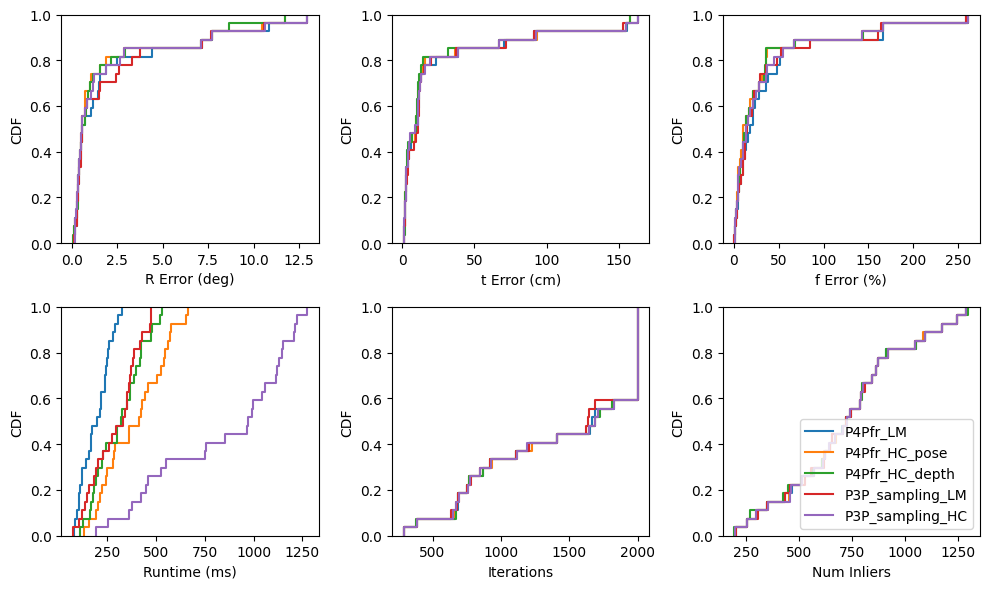

In [21]:
plotCDF_all(results, method_names, 'p3p')

# check individual error

In [16]:
query_name_list = list(errors.keys())
query_name = query_name_list[16]

In [17]:
corrs = gt_dirs / scene / "processed_remove_neighbours/Corrs/CorrsDict.pkl"
with open(corrs, 'rb') as f:
    corrs = pickle.load(f)
corrs[query_name]['imageID']


363

In [18]:
query_name

'cam2/IMG_20250330_115955_00_199_fisheye2.jpg'

In [19]:
df = showErrors(errors[query_name], method_names)
df

,R Error (deg),t Error (cm),f Error (%),Runtime (ms),Iterations,Num Inliers
p3p,6.728428,54.939963,0.000000,26.888212,101.0,2404.0
P4Pfr_LM,0.511498,11.836837,23.130522,324.880878,2000.0,722.0
P4Pfr_HC_pose,0.435592,3.882554,1.230437,654.359446,2000.0,726.0
P4Pfr_HC_depth,0.404705,3.640123,1.408654,521.079418,2000.0,723.0
P3P_sampling_LM,0.508304,11.640161,22.748091,468.256350,2000.0,723.0
P3P_sampling_HC,0.435592,3.882554,1.230437,1208.447745,2000.0,726.0
